In [1]:
from itertools import product, combinations, repeat
import math
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from Levenshtein import distance
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.examples.wood_ljungdahl import CHEMISTRY, MOLECULES, REACTIONS

theme_set(theme_minimal())

RUN_NAME = "2023-07-30_14-10"
RUN_DIR = Path("..") / "example" / "runs" / RUN_NAME

In [2]:
world = ms.World.from_file(rundir=RUN_DIR, device="cpu")
molnames = [d.name for d in world.chemistry.molecules]
steps = sorted(int(d.name.split("step=")[1]) for d in RUN_DIR.glob("step=*"))

In [3]:
cell_records = []
mol_records = []

for step in steps:
    world.load_state(statedir=RUN_DIR / f"step={step}", ignore_cell_params=True)
    cell_records.append({ "step": step, "cells": world.n_cells })
    
    for molname in molnames:
        mol_i = world.chemistry.molname_2_idx[molname]
        mol_records.append({
            "step": step,
            "molname": molname,
            "avg": world.molecule_map[mol_i].mean().item()
        })

cells_df = pd.DataFrame.from_records(cell_records)
mols_df = pd.DataFrame.from_records(mol_records)

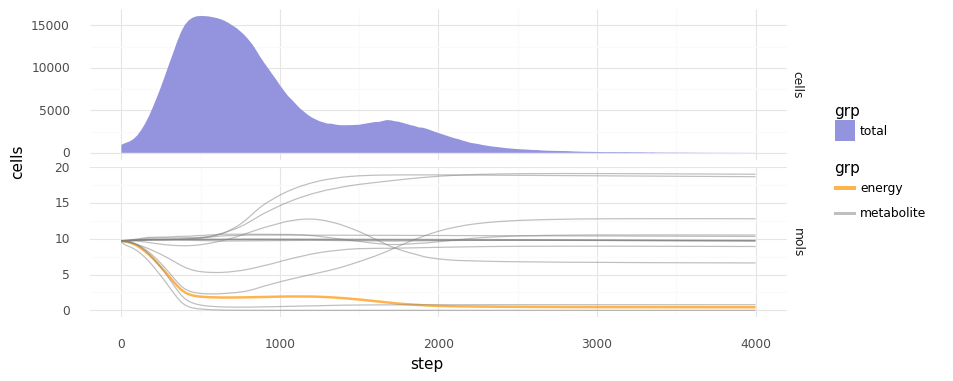

In [13]:
mols_df["grp"] = "metabolite"
mols_df.loc[mols_df["molname"] == "ATP", "grp"] = "energy"
mols_df["grp"] = pd.Categorical(mols_df["grp"], ["energy", "metabolite"])
mols_df["df"] = "mols"

cells_df["grp"] = "total"
cells_df["df"] = "cells"

(ggplot()
    + geom_area(aes(x="step", y="cells", fill="grp"), data=cells_df)
    + geom_line(aes(x="step", y="avg", color="grp", alpha="grp", size="grp", group="molname"), data=mols_df)
    + facet_grid("df ~ .", scales="free_y")
    + scale_fill_manual(["#9494DE"])
    + scale_color_manual(["#FFB34D", "gray"])
    + scale_alpha_manual([1.0, 0.5])
    + scale_size_manual([1.0, 0.5])
    + theme(figure_size=(9, 4)))

In [16]:
step = 1500
world.load_state(statedir=RUN_DIR / f"step={step}", ignore_cell_params=True)

top_labels = {f"CL{i}": d[0] for i, d in enumerate(Counter(world.cell_labels).most_common(n=2))}

In [17]:
cellmap_records = []
for step in [50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 1000, 1500, 2000, 2500]:
    world.load_state(statedir=RUN_DIR / f"step={step}", ignore_cell_params=True)
    
    for cell_i in range(world.n_cells):
        x, y = world.cell_positions[cell_i].tolist()
        label = world.cell_labels[cell_i]
        genome = world.cell_genomes[cell_i]
        cellmap_records.append({"step": step, "x": x, "y": y, "label": label})

cellmaps_df = pd.DataFrame.from_records(cellmap_records)

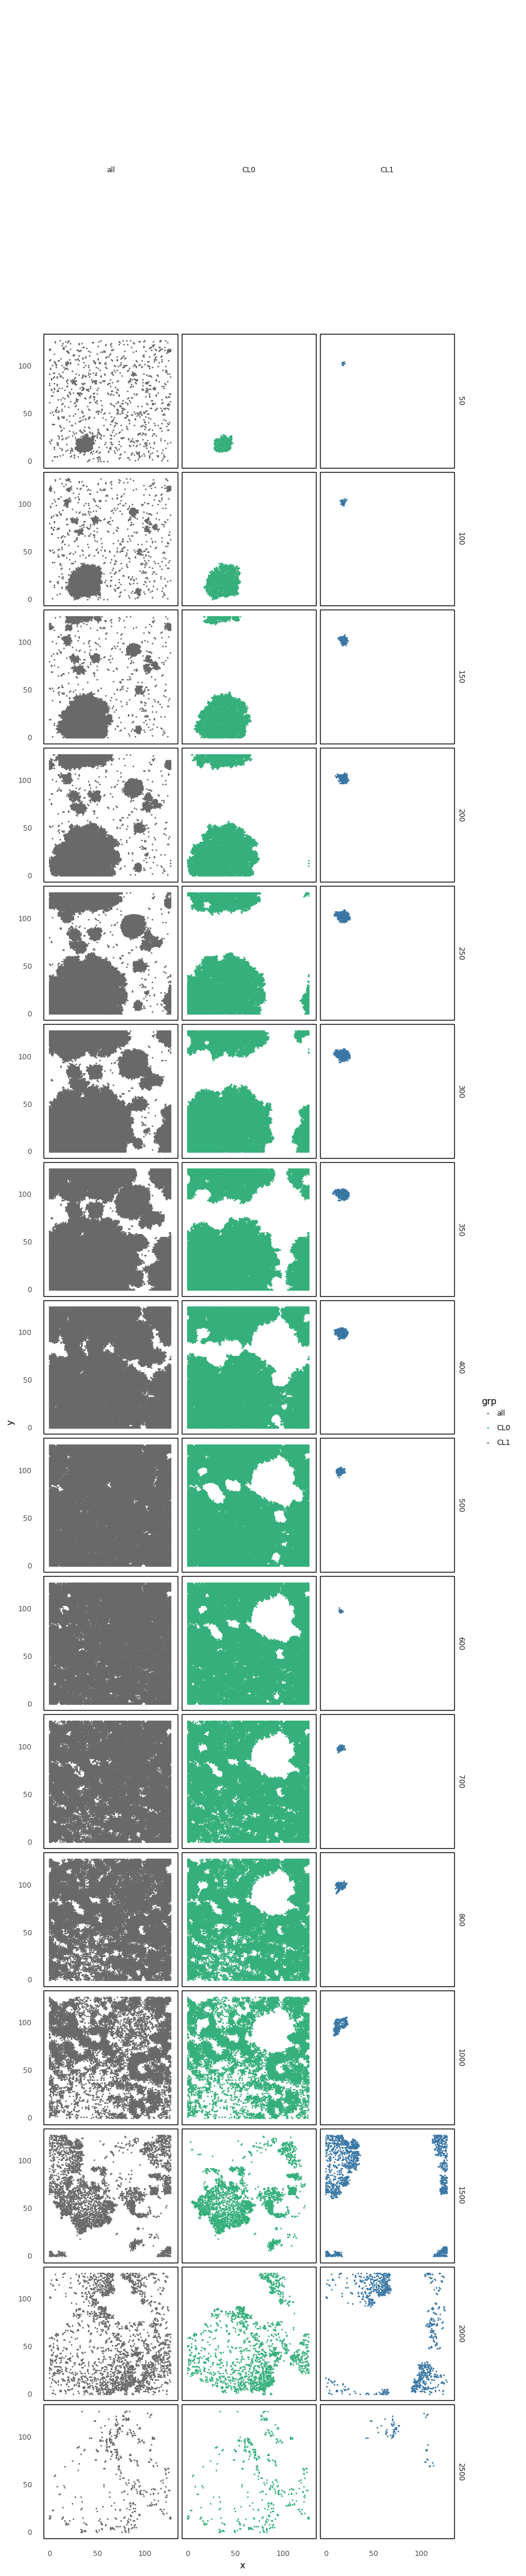

<ggplot: (8736950047240)>

In [25]:
all_df = cellmaps_df.copy()
all_df["grp"] = "all"

cl0_df = cellmaps_df[cellmaps_df["label"] == top_labels["CL0"]].copy()
cl0_df["grp"] = "CL0"

cl1_df = cellmaps_df[cellmaps_df["label"] == top_labels["CL1"]].copy()
cl1_df["grp"] = "CL1"

df = pd.concat([all_df, cl0_df, cl1_df], ignore_index=True)
df["grp"] = pd.Categorical(df["grp"], ["all", "CL0", "CL1"])

axis_lims = (0, world.map_size)
(ggplot(df, aes(x="x", y="y"))
    + geom_point(aes(color="grp"), size=.1)
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_color_manual(["dimgray", "#35AF7B", "#3976A4"])
    + facet_grid("step ~ grp")
    + theme(
        figure_size=(9, 2),
        panel_border=element_rect(colour="black", fill=None, size=1),
        panel_background=element_blank(),
        panel_grid_major=element_blank(), 
        panel_grid_minor=element_blank(),
    ))